In [1]:
%load_ext autoreload
%autoreload 2
# from gtd2d import gtd2d
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import open3d as o3d
import matplotlib
import matplotlib.cm as cm
from tqdm import tqdm
import pickle
import scipy.sparse

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [48]:
path = "C:/Users/schiavaz/lava-nc/depth/"
dataset = "data/esim_data/curvy/"

In [49]:
with open(path + dataset + 'results/result.pkl', 'rb') as f:
    out = pickle.load(f)

In [50]:
# runner.vel_input_buffer

In [51]:
# out = runner.run()

In [52]:
raw_depths_sparse = out["raw_depths"]
mean_depths_sparse = out["mean_depths"]

In [53]:
out["times"].shape

(2999,)

In [54]:
# raw_depths = raw_depths_sparse 
# mean_depths = mean_depths_sparse 

In [55]:
raw_depths = np.array([s.toarray() for s in raw_depths_sparse]) 
mean_depths = np.array([s.toarray() for s in mean_depths_sparse]) 

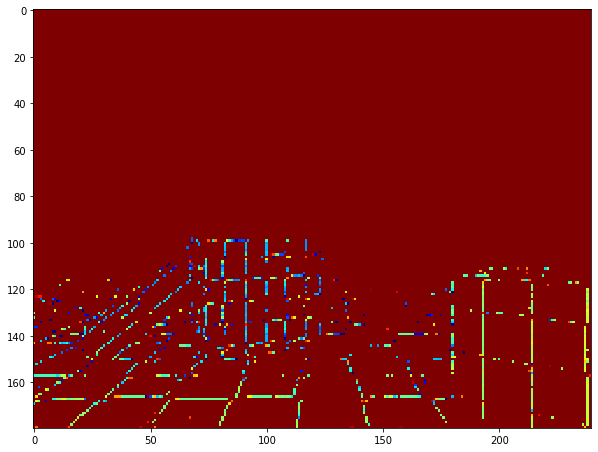

In [56]:
plt.figure(figsize=(10, 10))
m = plt.imshow(raw_depths[200:240].sum(axis=0), interpolation="none", cmap="jet_r", vmin=0, vmax=3)
#plt.colorbar(m)
# print(out["times"][2000])

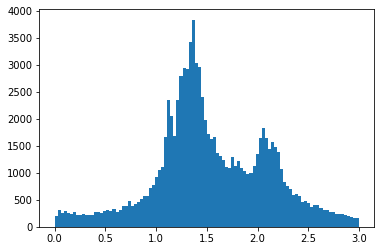

In [57]:
plt.hist(raw_depths.flatten(), 100, range=(0.001, 3));

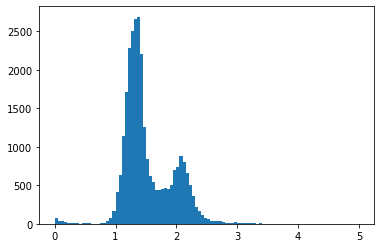

In [58]:
plt.hist(mean_depths.flatten(), 100, range=(0.0001, 5));

In [59]:
mean_depths

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [60]:
idx = 5
U = flow_u[idx:idx+5].sum(axis=0)
V = flow_v[idx:idx+5].sum(axis=0)
m = np.sqrt(U**2 + V**2)

NameError: name 'flow_u' is not defined

In [ ]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(U[::1, ::1], V[::1, ::1], m[::1, ::1], cmap="jet_r")
plt.gca().invert_yaxis()

In [ ]:
m = plt.imshow(U, interpolation="none")
plt.colorbar(m)

In [ ]:
poses = np.loadtxt(path + dataset + "groundtruth.txt")
poses[:, [1, 2, 3]] = poses[:, [2, 3, 1]]
calib = np.loadtxt(path + dataset + "calib.txt")
# calib[0] = 200
# calib[1] = 200
# calib[2] = 120
# calib[3] = 90
calib = calib / 1

In [68]:
depths = raw_depths[::10]
times = out["times"][::10]

In [69]:
def _image2pointcloud(d, v_range=None):
    points = []
    for x in range(d.shape[1]):
        for y in range(d.shape[0]):
            if np.isnan(d[y, x]):
                continue
            if v_range != None:
                if v_range[0] > d[y, x] or d[y, x] > v_range[1]:
                    continue
            points.append([x, y, d[y, x]])
    return np.array(points)

In [108]:
def project3d(points, calib, pose):
    K = np.array([
        [calib[0], 0, calib[2]],
        [0, calib[1], calib[3]],
        [0, 0, 1]
    ])

    t = pose[1:4].reshape(3, 1)
    q = pose[4:]

    r = R.from_quat(q)
    r_m = r.as_matrix()

    K_b = np.block([
        [K, np.zeros((3, 1))],
        [np.zeros((1, 3)), 1]
    ])
    rt_b = np.block([
        [r_m, t],
        [np.zeros((1, 3)), 1]
    ])

    proj = []
    points = points[points[:,2] != 0.0]
    if points.size == 0:
        return np.array([])
    tmp = points[:, 2]
    a = np.ones(points.shape[0]) / points[:, 2]
    points = np.c_[points[:, :2], np.ones(points.shape[0])]
    points = np.c_[points, a]
    points = points.transpose()
    
    proj = tmp * (np.linalg.inv(K_b @ rt_b) @ points)
#     for p in points:
#         if p[2] == 0:
#             continue
#         po = np.array([p[0], p[1], 1, 1 / p[2]])
#         test = p[2] * np.linalg.inv(K_b @ rt_b) @ po
#         proj.append(test.transpose())

#     proj = np.array(proj)
    proj = proj.transpose()
    return proj

In [109]:
projected_points = np.zeros((1, 4))
ps = []
p_init = poses[0]
for i, d in enumerate(tqdm(depths)):
    points = _image2pointcloud(d)

    idx = np.searchsorted(poses[:, 0], times[i])
#     print(times[i])
    p0 = poses[idx - 1]
    p1 = poses[idx]
    y = (times[i] - p0[0]) / (p1[0] - p0[0])
    p = (p0 * (1 - y) + p1 * (y))
    p[1:4] = p[1:4].reshape(1, 3) @ np.diag([-1, 1, 1])
    #p = poses[0]
#     print("p0: {},\np1:{},\np:{}".format(p0[:4], p1[:4], p[:4]))
    ps.append([p[2], p[3], p[1]])
    
    proj = project3d(points, calib, p)
    if proj.size == 0:
        continue
    projected_points = np.concatenate((projected_points, proj))

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:31<00:00,  9.56it/s]


In [110]:
def points_to_open3d_pointcloud(points, cmap="jet_r", z=2):

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    minima = min(points[:, z])
    maxima = max(points[:, z])
    print(minima)
    print(maxima)
    print("---")

    norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cmap)

    colors = mapper.to_rgba(points[:, z])[:,:3]
    print(colors.shape)

    pcd.colors = o3d.utility.Vector3dVector(colors)

    return pcd

In [111]:
projected_points

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.29495254,  2.25267421,  0.01172156,  1.        ],
       [ 1.31016747,  2.25267422, -0.06142716,  1.        ],
       ...,
       [ 1.69283817,  1.85294471, -0.76176523,  1.        ],
       [ 1.70468201,  1.82093434, -0.77651302,  1.        ],
       [ 1.73979138,  1.37739057, -0.97482935,  1.        ]])

In [112]:
proj = projected_points[projected_points[:,2] > -3]
# proj = projected_points
pcd = points_to_open3d_pointcloud(proj[:,:3], cmap="jet", z=1)

o3d.visualization.draw_geometries([pcd])

-39.593893026219334
2.369312076581377
---
(10122, 3)


In [ ]:
pcd_d = pcd.random_down_sample(0.2)
pcd_f, l = pcd_d.remove_radius_outlier(nb_points=15, radius=0.1)
# pcd_f, l = pcd_d.remove_statistical_outlier(nb_neighbors=30, std_ratio=0.2, print_progress=True)

In [ ]:
pcd_b = pcd_f.voxel_down_sample(voxel_size=0.02)

In [ ]:
o3d.visualization.draw_geometries([pcd_f])

In [ ]:
ps = np.array(ps)
ps_b = np.copy(ps)

In [ ]:
ps_b[:, 0] += 3

In [ ]:
# proj = projected_points[projected_points[:,2] > -3]
ps_pcd = points_to_open3d_pointcloud(ps_b, cmap="spring", z=2)

o3d.visualization.draw_geometries([pcd_b, ps_pcd])

In [ ]:
gt_depths = np.genfromtxt(path + dataset + "depthmaps.txt", dtype="str")

In [ ]:
for t, d in gt_depths[10:-30]:
    idx = np.searchsorted(times, t)
    
    l = idx - 25 if idx >= 25 else 0
    h = idx + 25 if idx < times.size - 25 else times.size
    
    n_meas = (raw_depths[l:h] != 0).sum(axis=0)
    m_depth = np.divide(raw_depths[l:h].sum(axis=0), n_meas, where=n_meas!=0.0)
    
    diff = np.abs(d - m_depth)
    print(diff)

In [ ]:
id_start = 100
x = 10
y = 80
timestep = 0.005
times = out["times"]

In [ ]:
debug = out["debug"]
debug.shape

In [ ]:
avg_log = out["avg_debug"]
avg_trace = avg_log[y,x,id_start:] * timestep

In [ ]:
depth_log = np.copy(out["raw_depths"])
depth_log = np.swapaxes(depth_log, 0, -1)
output_trace = depth_log[y, x, id_start:] #/ timestep
output_trace[output_trace == 0.0] = np.nan

In [ ]:
trace = debug[y,x,id_start:] * timestep
trace[trace == 0.0] = np.nan

times = times[id_start:]

In [ ]:
plt.figure(figsize=(20, 10))
plt.scatter(times, trace, s=10)
plt.plot(times, avg_trace, c="red")
plt.scatter(times, output_trace, c="yellow")

In [ ]:
vals = trace
ema = np.nan
avg = np.nan
emav = np.nan
med = np.nan
n = 0
a = 0.125
print(a)
at = 0.25
av = 0
ema_l = []
ema_vl = []
avg_l = []
val_l = []
time_l = []
med_l = []
v = vals[0]
last_t = 0
prev_v = np.nan
for i, v in enumerate(vals):
    if np.isnan(v):
        if np.isnan(prev_v):
            continue
    else:
        t = times[i]  
        av = 1 - np.exp((-t + last_t)/0.2)
        #print("av: {}, last_t: {}, t: {}, a:{}".format(av, last_t, t, a))
        #last_t = av*t + (1-av)*last_t
        last_t = t
        #print("idx: {}, v: {}, t: {}".format(idx, v, t))
        if np.isnan(ema): 
            ema = v
            avg = v
            emav = v
            n += 1
            med = v
        else:
            avg = (avg * n + v) / (n + 1)
            ema += a * (v - ema)
            emav = av*v + (1-av)*emav
            n += 1
            med = np.nanmedian(vals[i-10:i+1])
    #prev_v = v
    time_l.append(t)
    ema_l.append(ema)
    avg_l.append(avg)
    val_l.append(v)
    ema_vl.append(emav)
    med_l.append(med)

In [ ]:
plt.figure(figsize=(20, 10))
# plt.plot(time_l, val_l, label="vals")
plt.plot(time_l, avg_l, label="avg")
plt.plot(time_l, ema_l, label="ema")
plt.plot(time_l, ema_vl, label="emav")
# plt.plot(time_l, med_l, label="med")
plt.scatter(times, vals)
plt.legend()

In [ ]:
avg_map = np.copy(avg_log) * timestep
avg_map[avg_map == 0.0] = np.nan
avg_map = avg_map[:, :, 100:110]
# avg_map_n = np.divide(np.nansum(avg_map, axis=-1), n_avg, out=np.zeros_like(n_avg))
m = plt.imshow(np.nansum(avg_map, axis=-1) / 10, cmap="jet_r", vmax=3)
plt.colorbar(m)

In [ ]:
t = (avg_map != np.nan).sum(axis=-1)

In [ ]:
plt.imshow(t)

In [ ]:
t

In [ ]:
plt.hist(avg_map.flatten(), 100);

In [ ]:
np.any(np.isclose(avg_map))

In [ ]:
depth_log.shape

In [ ]:
plt.hist(depth_log.flatten(), 100, range=(0.001, 5));

In [ ]:
output_trace = depth_log[y, x, id_start:]

In [ ]:
plt.hist(output_trace, 100);

In [ ]:
raw_depths

In [ ]:
t = np.array([
    [1, 0, 1],
    [0, 1, 1], 
    [0, 0, 1]
])

In [ ]:
m = np.ma.masked_where(t == 0, t)

In [ ]:
m.compressed()

In [ ]:
import scipy.sparse

In [ ]:
s = scipy.sparse.csr_matrix(t)

In [ ]:
print(s)

In [ ]:
i, j, v = scipy.sparse.find(s)

In [ ]:
i

In [ ]:
j

In [ ]:
v

In [ ]:
type(s)

In [ ]:
l = np.empty((1, 4), dtype=object)

In [ ]:
l[..., 0] = s

In [ ]:
l[0]

In [ ]:
s.toarray()

In [ ]:
s = s * 2.3

In [ ]:
s

In [ ]:
gt_depths = np.load(path + dataset + "gt_depths.npy")

In [ ]:
gt_depths.shape

In [ ]:
gt_depths[0]

In [ ]:
gt_times = np.genfromtxt(path + dataset + "depthmaps.txt", dtype="str")

In [ ]:
gt_times.shape

In [ ]:
gt_times = gt_times[:, 0].astype(np.float64)

In [ ]:
gt_times.shape

In [ ]:
subsampling = 4
shape = (180, 240)
times = out["times"]
errors = []
rel_err = []

for i, t in enumerate(gt_times):
    if t > times[-1] or t < times[0]:
        continue
    idx = np.searchsorted(times, float(t))
    l = idx - 100 if idx >= 100 else 0
    h = idx + 100 if idx < times.size - 100 else times.size
    
    n_meas = (raw_depths[l:h] != 0).sum(axis=0)
    m_depth = np.divide(raw_depths[l:h].sum(axis=0), n_meas, where=raw_depths[l:h].sum(axis=0)!=0.0, out=np.zeros_like(n_meas, dtype=np.float64))
    
    gt_d = gt_depths[i, ::subsampling, ::subsampling]
    
    diff_r = np.subtract(m_depth, gt_d, where=m_depth!=0.0, out=np.zeros_like(m_depth))
    diff = np.abs(diff_r)
    
    diff_rel = np.divide(diff, gt_d, where=diff!=0.0, out=np.zeros_like(diff))
    
    diff[np.isclose(diff, 0.0)] = np.nan
    errors.append(diff)
    
    diff_rel[np.isclose(diff_rel, 0.0)] = np.nan
    rel_err.append(diff_rel)
    
errors = np.array(errors)

In [ ]:
print(np.nanmean(errors))
print(np.nanmedian(errors))
print(np.nanmean(rel_err))

In [ ]:
errors.shape

In [ ]:
plt.figure(figsize=(10, 10))
m = plt.imshow(np.nansum(errors[5:7], axis=0), interpolation="none")
plt.colorbar(m)

In [ ]:
idx = np.searchsorted(times, gt_times[60])

In [ ]:
idx

In [ ]:
plt.hist(errors[10].flatten(), 100, range=(-1, 1));

In [ ]:
plt.hist(gt_depths.flatten(), 100, range=(1, 2.1));
plt.axvline(1.4, c="red")
plt.axvline(1.5, c="red")

In [ ]:
plt.hist(mean_depths.flatten(), 100, range=(1, 3));
plt.axvline(1.5, c="red")
plt.axvline(1.4, c="red")
plt.axvline(2.0, c="red")

In [ ]:
plt.hist(raw_depths.flatten(), 100, range=(1, 3));
plt.axvline(1.5, c="red")
plt.axvline(1.4, c="red")
plt.axvline(2.0, c="red")

In [ ]:
plt.hist(errors.flatten(), 100, range=(0.0001, 1));